In [1]:
%matplotlib inline
import numpy as np
#from autograd import numpy as np
import bayesian_pdes as bpdes
from scipy import stats
import matplotlib.pyplot as plt
import mcmc
import sympy as sp
import os
%load_ext mcmc
%mcmc notebook

In [2]:
use_dummy_data = False
dummy_data_file = os.path.join('dummy_data', 'centered_blob')

In [64]:
scale = 1000
stim_current = 1.0

kernel_variance_mult = 1.0
kernel_ls = 0.3
conductivity_variance_mult = 1e-2
conductivity_ls = 0.4
run_time = 15

likelihood_variance = 1e-6 # variance for the observation model - based on the value from RA paper

In [4]:
baseline = np.loadtxt('recovered_rhos.csv', delimiter=',')
baseline_xy = baseline[:,:2]
baseline_fields = baseline[:,2:]

# Sheet Parameters

In [5]:
# important helpers!
def cart2pol(points):
    x = points[:,0]
    y = points[:,1]
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return np.column_stack([rho, phi])

def pol2cart(points):
    rho = points[:,0]
    phi = points[:,1]
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return np.column_stack([x, y])

def plot_circle(x, y, values, cmap=None):
    plt.tripcolor(x.ravel(), y.ravel(), values.ravel(), cmap=cmap)
    plt.colorbar()
    plt.legend()
    plt.axis('scaled')
    plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1);

In [6]:
# code for setting up the stim pattern
stim_pattern = np.zeros((7,8))
for i in xrange(7):
    stim_pattern[i,0] = 1
    stim_pattern[i, i+1] = -1
stim_pattern = stim_pattern*stim_current

In [7]:
meas_pattern = np.zeros((7,8))
meas_pattern[:,0] = 1
meas_pattern[:, 1:] = np.diag(-np.ones(7))

# Load Data

In [8]:
data_file = '../data/ST1trial3.DAT'
raw_data = np.loadtxt(data_file)

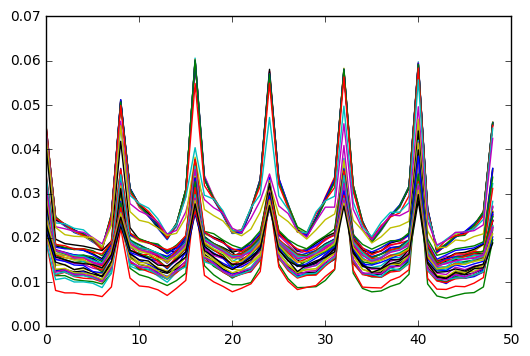

In [9]:
plt.plot(raw_data[:,1:].T);

In [10]:
raw_data.shape

(49, 50)

The data file format is as follows:
* Each row corresponds to a time
* The first element of the row gives the time index of the measurement
* The remaining columns give the measurements for each time
* These are divided into seven blocks.
    - Call the block $i$
    - Within the block the measurements correspond to electrodes $j=1,\dots,8$, $j\neq i$
    - Pair $(i,j)$ represents passing a current between electrode $i$ and electrode $j$ and measuring the voltage.
    - The voltage is measured between the _reference_ electrode at $1$ and the electrode located at $1+i$

_Is there not one too many electrodes here? This implies at some point we measure the voltage between 1 and 2 based on a current driven between 1 and 2._

_Is there a linear independence problem here? I still think there might be._

In [11]:
def data_to_dict(data):
    res = {}
    for r in data:
        time = r[0]
        other_data = r[1:]
        res[time] = scale*other_data.reshape((7,7))
    return res

In [12]:
data_dict = data_to_dict(raw_data)
# quick check to make sure the data dict matches expectation
assert np.all(data_dict[1][0] == scale*raw_data[0][1:8])

In [13]:
dummy_data = np.load(os.path.join(dummy_data_file, 'obs.npy'))
dummy_true_field = np.load(os.path.join(dummy_data_file, 'theta.npy'))

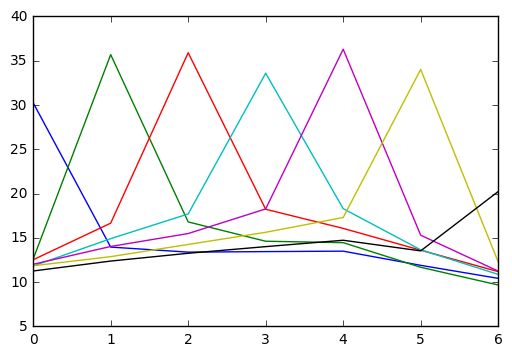

In [14]:
plt.plot(data_dict[run_time])

# Set Up

In [15]:
from bayesian_pdes.problems import eit

In [16]:
s_x, s_xbar, s_y, s_ybar = sp.symbols('x,xbar,y,ybar')
a, a_x, a_y = sp.symbols('a,a_x,a_y')
a_bar, a_x_bar, a_y_bar = sp.symbols('abar,a_xbar,a_ybar')
s_length_scale, s_variance = sp.symbols('l,sigma')
kernel = s_variance*sp.exp(-((s_x-s_xbar)**2 + (s_y-s_ybar)**2) / (2.*s_length_scale**2))
symbols = [[s_x, s_y, a, a_x, a_y], [s_xbar, s_ybar, a_bar, a_x_bar, a_y_bar], [s_length_scale, s_variance]]

Use:
\begin{align*}
    \nabla \cdot (\exp(a)\nabla u) &= \nabla \exp(a) \cdot \nabla u + \exp(a) \nabla^2 u \\
    &= \exp(a) \left( \nabla a \cdot \nabla u + \nabla^2 u \right) \\
    &= \exp(a) \left( a_x u_x + a_y u_y + u_{xx} + u_{yy} \right)
\end{align*}
and:
\begin{align*}
    \exp(a) \nabla u \cdot n &= \exp(a) (x u_x + y u_y)
\end{align*}
for the special case of a unit circular domain centered at the origin.

In [17]:
def A(k):
    return sp.exp(a)*(k.diff(s_x,s_x) + k.diff(s_y,s_y) + k.diff(s_x)*a_x + k.diff(s_y)*a_y)
def A_bar(k):
    return sp.exp(a_bar)*(k.diff(s_xbar,s_xbar) + k.diff(s_ybar,s_ybar) + k.diff(s_xbar)*a_x_bar + k.diff(s_ybar)*a_y_bar)
def B(k):
    return sp.exp(a)*(k.diff(s_x)*s_x + k.diff(s_y)*s_y)
def B_bar(k):
    return sp.exp(a_bar)*(k.diff(s_xbar)*s_xbar + k.diff(s_ybar)*s_ybar)

In [18]:
op_system = bpdes.operator_compilation.sympy_gram.compile_sympy(
    [A, B], [A_bar, B_bar],
    kernel,
    symbols,
    parallel=True
)

In [19]:
#op_system_factory = eit.EITFactory(kernel, symbols[0], symbols[1], symbols[2])

## Define the collocation grid

In [20]:
r = 1.0 # todo: just assume a unit radius, is this okay?
n_in_shell = 10

In [21]:
def construct_shell(radii):
    r_spacing = radii[1] - radii[0]
    coords = [np.array([[0.,0.]])]
    for r in radii:
        # at each 'shell' we want a roughly equal number of theta around the diameter.
        # each theta should be about r_spacing apart
        n_theta = np.round(2*np.pi*r / r_spacing)
        thetas = np.linspace(0, 2*np.pi, n_theta+1)[:-1]
        x = np.cos(thetas)
        y = np.sin(thetas)
        coords.append(r*np.c_[x,y])
    coords = np.concatenate(coords)
    return coords


In [22]:
shell_radii = np.linspace(0, r, n_in_shell)[1:-1]
design_int = construct_shell(shell_radii)

In [23]:
n_bdy = 64
bdy_theta = np.linspace(0, 2*np.pi, n_bdy+1)
design_bdy = pol2cart(np.c_[np.ones(n_bdy), bdy_theta[:-1]]) 

# define the mapping from boundary collocation point to sensor
bdy_sensor_skip = 8
sensor_ixs = np.arange(0, len(design_bdy), bdy_sensor_skip)
is_sensor_flags = np.in1d(np.arange(len(design_bdy)), sensor_ixs)

sensor_xy = design_bdy[is_sensor_flags]
non_sensor_xy = design_bdy[~is_sensor_flags]
print('{} sensors'.format(len(sensor_xy)))
print('{} non-sensors'.format(len(non_sensor_xy)))

8 sensors
56 non-sensors


In [24]:
# for now we impose the BC only at the sensor locations and impose the interior condition at non-sensor bdy points
modified_design_int = np.row_stack([design_int, non_sensor_xy])
modified_design_bdy = sensor_xy

In [25]:
full_design = np.row_stack([modified_design_int, modified_design_bdy])
len(full_design)

291

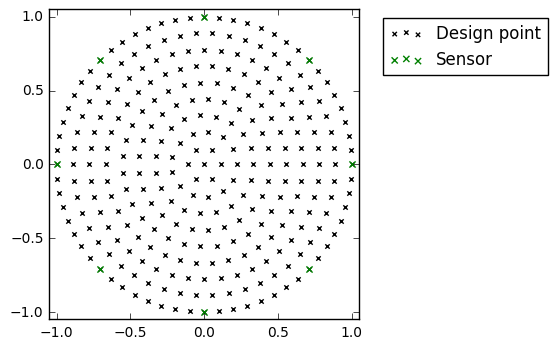

In [26]:
# plot design points
plt.figure(figsize=(4,4))
plt.scatter(design_int[:,0], design_int[:,1], marker='x', color='black', s=10)
plt.scatter(design_bdy[:,0], design_bdy[:,1], marker='x', color='black', s=10, label='Design point')
plt.scatter(sensor_xy[:,0], sensor_xy[:,1], marker='x', color='green', label='Sensor')
plt.xlim(-r*1.05,r*1.05);plt.ylim(-r*1.05,r*1.05)
plt.legend(loc=2, bbox_to_anchor=(1.05,1))

## Define the Potential

In [27]:
# todo: choose this in a more principled way
length_scale = 0.3
fun_args = np.array([kernel_ls, kernel_variance_mult])

In [28]:
def construct_posterior(theta, debug=False):
    a_int, a_bdy, a_x, a_y = theta_to_a(theta,
                                        modified_design_int.shape[0], 
                                        modified_design_bdy.shape[0]
                                       )
    
    augmented_int = np.column_stack([modified_design_int, a_int, a_x, a_y])
    augmented_bdy = np.column_stack([modified_design_bdy, a_bdy, np.nan*np.zeros((a_bdy.shape[0], 2))])
    obs = [
        (augmented_int, None),
        (augmented_bdy, None)
    ]
    posterior = bpdes.collocate(
        op_system.operators,
        op_system.operators_bar,
        obs,
        op_system,
        fun_args,
        inverter='np'
    )
    return posterior

In [29]:
def phi(theta, debug=False):
    # first solve forward
    posterior = construct_posterior(theta, debug=debug)
    # now determine voltage at the sensor locations
    # we have seven observations so take one for each sensor other than sensor 1, the reference sensor
    augmented_locations = np.column_stack([sensor_xy, np.nan*np.zeros((8,3))])
    mu_mult, Sigma = posterior.no_obs_posterior(augmented_locations)
    
    # now need to iterate the stim patterns and compute the residual
    data = data_dict[run_time] if not use_dummy_data else dummy_data
    rhs_int = np.zeros((len(modified_design_int), 1))
    
    Sigma_obs = np.dot(meas_pattern, np.dot(Sigma, meas_pattern.T))
    likelihood_cov = Sigma_obs + likelihood_variance*np.eye(Sigma_obs.shape[0])
    #likelihood_cov = likelihood_variance*np.eye(Sigma_obs.shape[0])
    likelihood_dist = stats.multivariate_normal(np.zeros(Sigma_obs.shape[0]), likelihood_cov)
    
    if debug:
        print("Sigma diag: {}\tCondition:{} \t Augmented Condition: {}".format(np.diag(Sigma), np.linalg.cond(Sigma), np.linalg.cond(likelihood_cov)))
    
    likelihood = 0
    for voltage, current in zip(data, stim_pattern):
        rhs_bdy = current[:,None]
        rhs = np.row_stack([rhs_int, rhs_bdy])
        
        model_voltage = np.dot(meas_pattern, np.dot(mu_mult, rhs))
        
        residual = voltage.ravel() - model_voltage.ravel()
        this_likelihood = likelihood_dist.logpdf(residual)
        if debug:
            print("Model|True\n {}".format(np.c_[model_voltage, voltage]))
            print("Likelihood: {}   |   Residual: {}".format(this_likelihood, np.abs(residual).sum()))
        likelihood += this_likelihood
    return -likelihood

In [30]:
data_dict[run_time]

array([[ 30.25  ,  12.61  ,  12.53  ,  11.83  ,  12.02  ,  11.85  ,
         11.2615],
       [ 13.96  ,  35.69  ,  16.66  ,  14.91  ,  14.03  ,  12.88  ,
         12.3815],
       [ 13.39  ,  16.8   ,  35.9   ,  17.7   ,  15.49  ,  14.26  ,
         13.2615],
       [ 13.45  ,  14.62  ,  18.23  ,  33.59  ,  18.27  ,  15.63  ,
         14.0115],
       [ 13.5   ,  14.46  ,  16.07  ,  18.3   ,  36.3   ,  17.3   ,
         14.7315],
       [ 11.9   ,  11.68  ,  13.61  ,  13.65  ,  15.3   ,  34.02  ,
         13.5315],
       [ 10.43  ,   9.68  ,  11.19  ,  10.88  ,  11.25  ,  12.29  ,  20.23  ]])

## Set up Proposal Matrix

In [31]:
proposal_kernel = kernel
def diff_x(k):
    return k.diff(s_x)
def diff_y(k):
    return k.diff(s_y)
def diff_x_bar(k):
    return k.diff(s_xbar)
def diff_y_bar(k):
    return k.diff(s_ybar)

proposal_op_system = bpdes.operator_compilation.sympy_gram.compile_sympy(
    [diff_x, diff_y], 
    [diff_x_bar, diff_y_bar], 
    proposal_kernel,
    [[s_x, s_y], [s_xbar, s_ybar], [s_length_scale, s_variance]]
)

In [32]:
proposal_design = construct_shell(np.linspace(0,1,8))

In [65]:
proposal_fun_args = np.array([conductivity_ls, conductivity_variance_mult])
proposal_cov = bpdes.collocation.compute_operator_matrix(
    [()],
    [()],
    [proposal_design],
    [proposal_design],
    proposal_op_system,
    proposal_fun_args
)
proposal_lhs_mat = bpdes.collocation.compute_operator_matrix(
    [(), diff_x, diff_y], 
    [()],
    [full_design, modified_design_int, modified_design_int],
    [proposal_design],
    proposal_op_system,
    proposal_fun_args
)
proposal_cov_inv = np.linalg.inv(proposal_cov)
np.linalg.cond(proposal_cov)

44870629163543.5

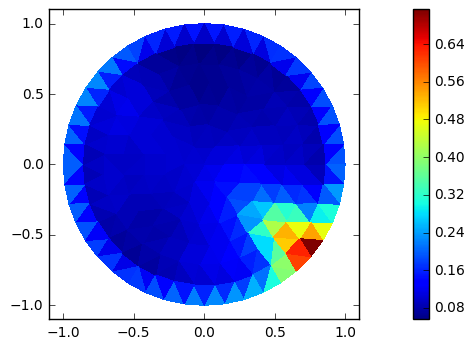

In [66]:
rhomin = 0.01
rho = baseline_fields[:,run_time-1][:,None]
rho[rho < rhomin] = rhomin
conduct = np.log(1./rho)
p = bpdes.collocate([()], [()], 
                    [(baseline_xy, conduct)],
                    proposal_op_system, 
                    np.array([0.12, 1.0]))

true_field, _ = p(proposal_design)
true_field = true_field.ravel()
plot_circle(proposal_design[:,0], proposal_design[:,1], np.exp(true_field))

In [67]:
# TO DO:
# * Swap to simulating only a lower dimensional version of the field
proposal_dot_mat = np.dot(proposal_lhs_mat, proposal_cov_inv)
def theta_to_a(theta, sz_int, sz_bdy):
    theta = np.real_if_close(theta)
    theta_mod = np.dot(proposal_dot_mat, theta[:,None])
    kappa_int = theta_mod[:sz_int]
    kappa_bdy = theta_mod[sz_int:sz_int+sz_bdy]
    grad_kappa_x = theta_mod[sz_int+sz_bdy:2*sz_int+sz_bdy]
    grad_kappa_y = theta_mod[2*sz_int+sz_bdy:]
    return kappa_int, kappa_bdy, grad_kappa_x, grad_kappa_y

In [68]:
import scipy.optimize
def phi_const(k):
    return phi(k*np.ones(proposal_cov.shape[0]))
best_const = scipy.optimize.minimize_scalar(phi_const)

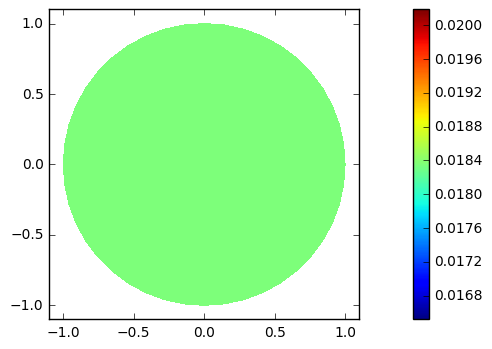

In [73]:
mcmc.pcn.sqrtm_mode = mcmc.pcn.SQRTM_SCIPY
proposal = mcmc.pcn.proposal(0.02, proposal_cov)
#kappa_0 = np.random.multivariate_normal(np.zeros(proposal_cov.shape[0]), proposal_cov)
#kappa_0 = proposals[-1,:]
#kappa_0 = dummy_true_field[:len(full_design)]
kappa_0 = best_const.x*np.ones(proposal_cov.shape[0])
plot_circle(proposal_design[:,0], proposal_design[:,1], np.exp(kappa_0))

In [74]:
print phi(kappa_0, False)
print phi(true_field, False)

148210.525652
2941638350.82


In [75]:
proposals, acceptances = mcmc.pCN(10000, proposal, phi, kappa_0)

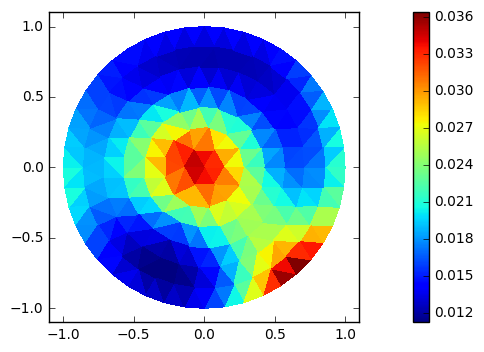

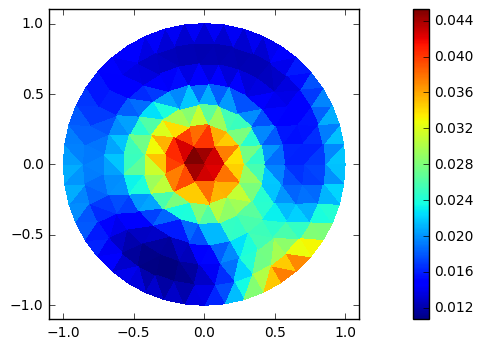

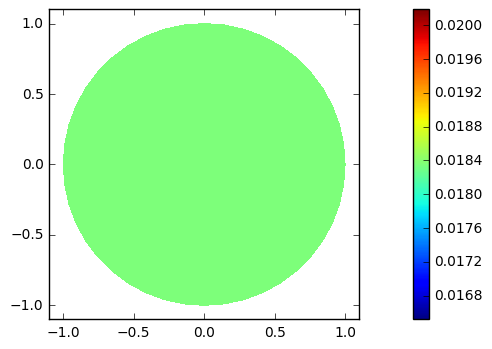

In [76]:
thin = 1
burn = int(proposals.shape[0]) / 2


recovered_field = proposals[burn::thin, :len(full_design)].mean(axis=0)
plot_circle(proposal_design[:,0], proposal_design[:,1], np.exp(recovered_field))
plt.savefig('results/t={}_field.pdf'.format(run_time))
plt.figure()
plot_circle(proposal_design[:,0], proposal_design[:,1], np.exp(proposals[-1, :len(full_design)]))
plt.figure()
plot_circle(proposal_design[:,0], proposal_design[:,1], np.exp(kappa_0[:len(full_design)]))

In [78]:
print phi(recovered_field)
print phi(kappa_0)

1906.80177218
148210.525652


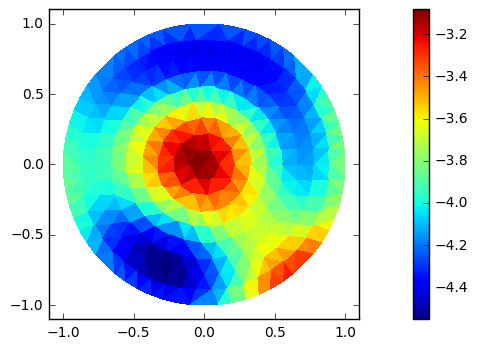

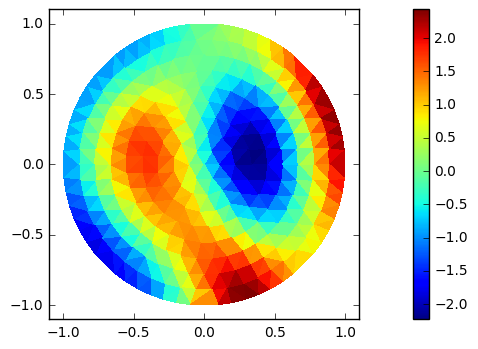

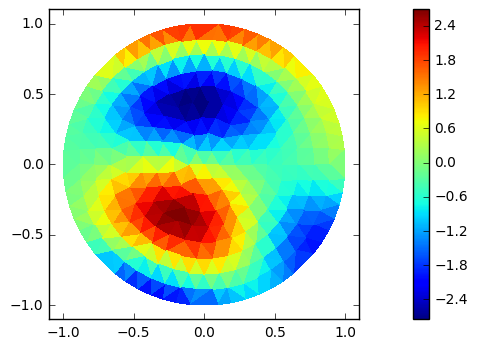

In [79]:
a_int, a_bdy, a_x, a_y = theta_to_a(proposals[-1,:], len(modified_design_int), len(modified_design_bdy))
plot_circle(modified_design_int[:,0], modified_design_int[:,1], a_int)
plt.figure()
plot_circle(modified_design_int[:,0], modified_design_int[:,1],a_x)
plt.figure()
plot_circle(modified_design_int[:,0], modified_design_int[:,1], a_y)

# Diagnostics

In [80]:
field_to_test = recovered_field

In [81]:
phi(field_to_test, True)

Sigma diag: [ 0.07322769  0.07599754  0.07846077  0.08035185  0.08160095  0.0783693
  0.07849621  0.07502797]	Condition:3663.64599082 	 Augmented Condition: 726.733107877
Model|True
 [[ 30.75432375  30.25      ]
 [ 12.9856083   12.61      ]
 [ 11.71943129  12.53      ]
 [ 12.87010331  11.83      ]
 [ 14.24156903  12.02      ]
 [ 14.55335939  11.85      ]
 [ 13.21014885  11.2615    ]]
Likelihood: -207.185981272   |   Residual: 9.60418134343
Model|True
 [[ 13.08667545  13.96      ]
 [ 37.38993647  35.69      ]
 [ 18.8763947   16.66      ]
 [ 16.10245507  14.91      ]
 [ 15.65477013  14.03      ]
 [ 16.44109999  12.88      ]
 [ 15.31913462  12.3815    ]]
Likelihood: -386.894351769   |   Residual: 14.1056155264
Model|True
 [[ 11.28689645  13.39      ]
 [ 15.50039983  16.8       ]
 [ 35.20239223  35.9       ]
 [ 15.12414524  17.7       ]
 [ 13.45055239  15.49      ]
 [ 14.04996394  14.26      ]
 [ 13.47386591  13.2615    ]]
Likelihood: -255.795069354   |   Residual: 9.13801581421
Model|True

1906.8017721759566

In [82]:
p = construct_posterior(field_to_test)
mu_mult, cov = p.no_obs_posterior(np.column_stack([full_design, np.empty((full_design.shape[0],3))]))

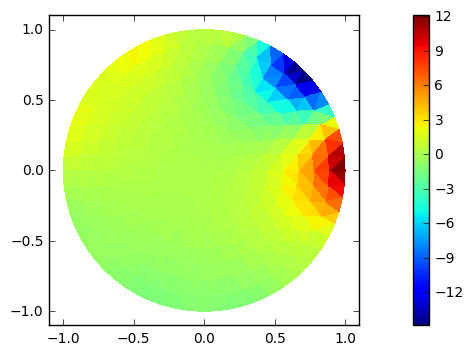

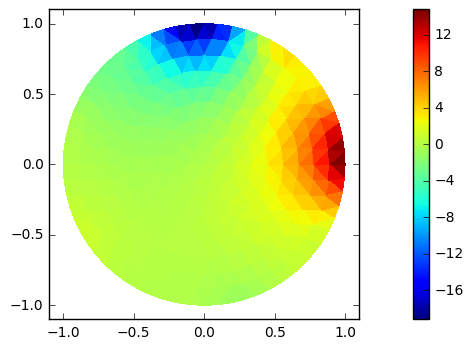

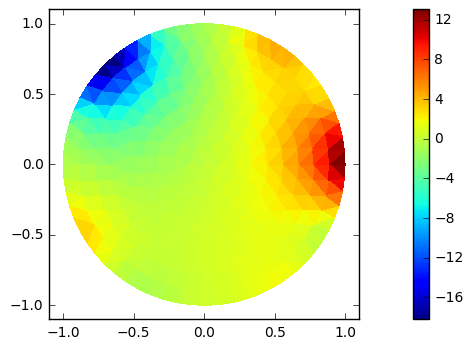

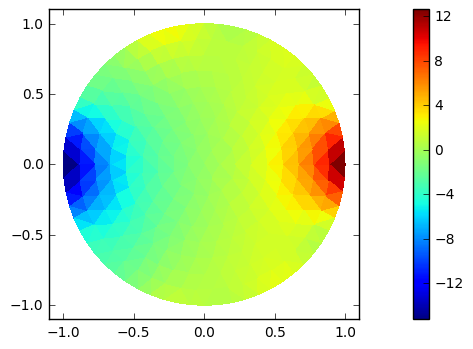

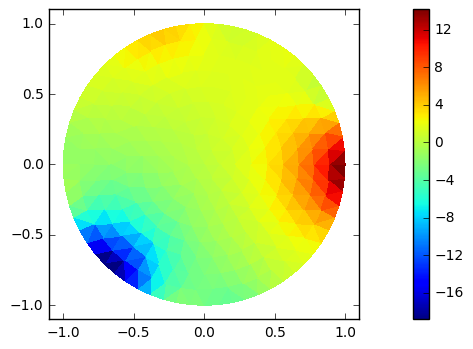

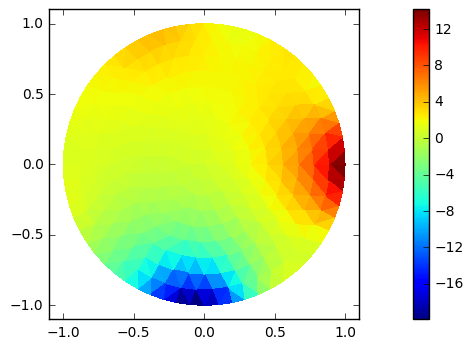

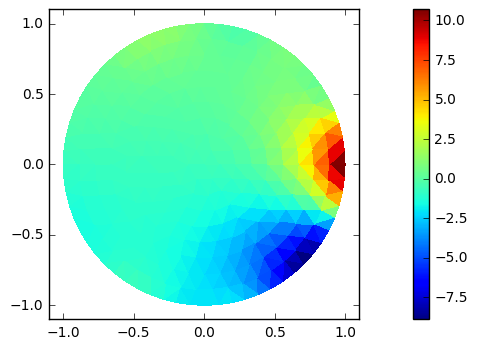

In [83]:
for i in xrange(stim_pattern.shape[0]):
    mu = mu_mult.dot(np.row_stack([
                np.zeros((len(modified_design_int), 1)),
                stim_pattern[i][:,None]
                ]
                             ))
    plt.figure()
    plot_circle(full_design[:,0], full_design[:,1], mu)

In [84]:
np.save('results/t={}_samples.npy'.format(run_time), recovered_field)

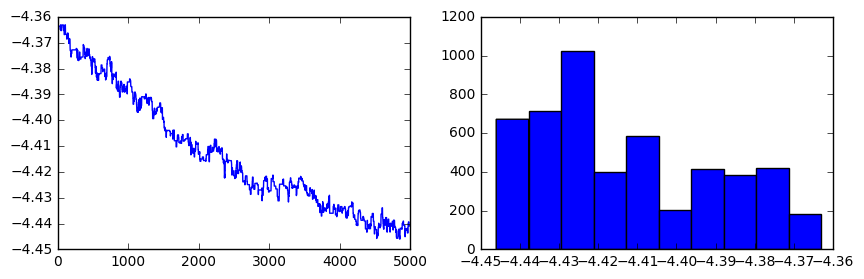

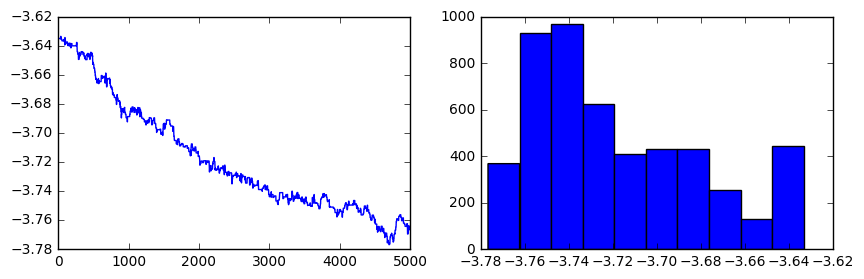

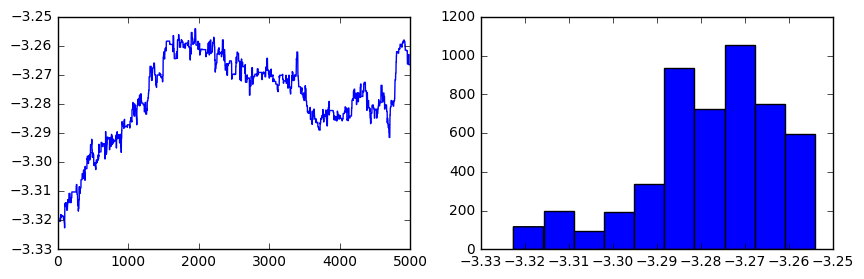

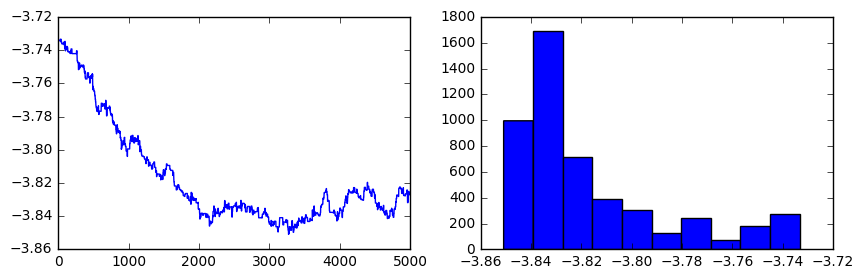

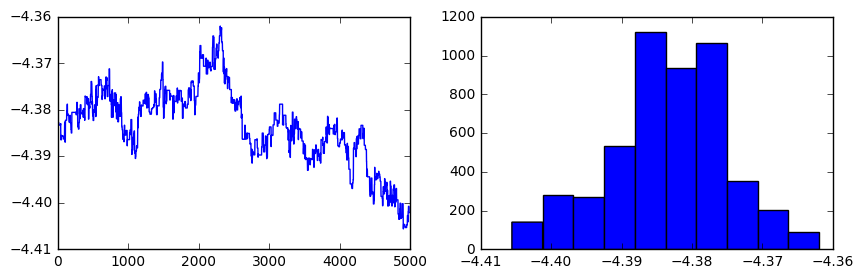

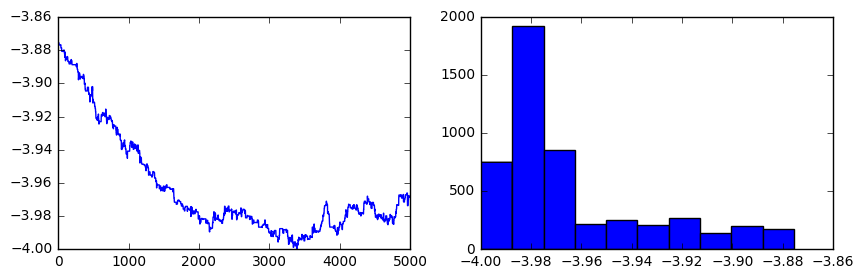

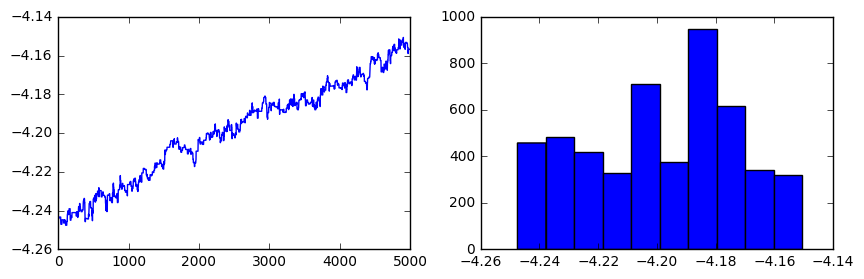

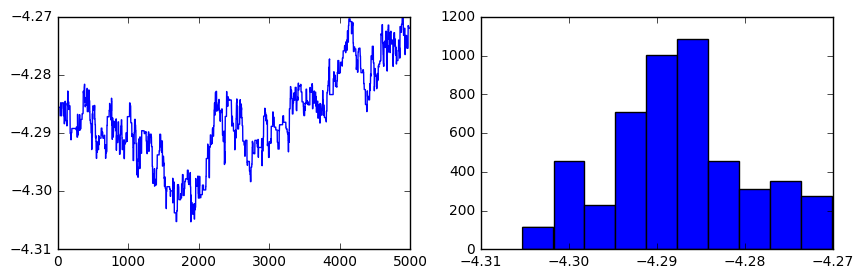

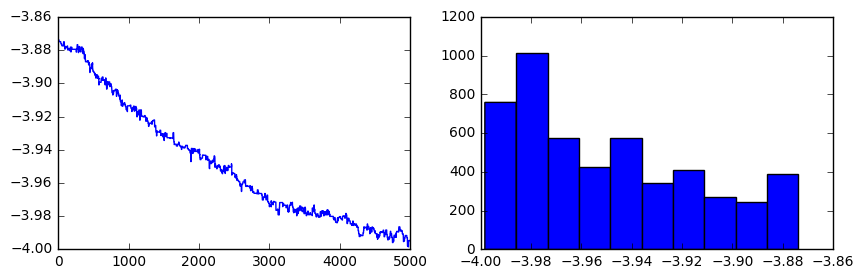

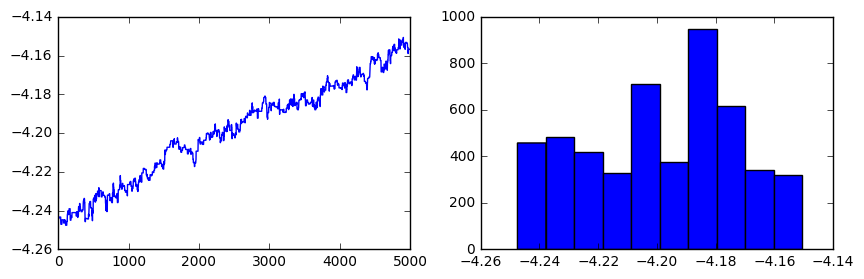

In [85]:
for i in np.random.choice(proposals.shape[1], 10):
    plt.figure(figsize=(10,3))
    plt.subplot(121)
    plt.plot(proposals[burn::thin,i])
    plt.subplot(122)
    plt.hist(proposals[burn::thin,i])

In [49]:
phi(proposals[-1,:], True)

Sigma diag: [ 0.07287308  0.07532766  0.07721519  0.07992251  0.08078505  0.07818506
  0.07825646  0.0746456 ]	Condition:3780.15273658 	 Augmented Condition: 737.323201454
Model|True
 [[ 30.91499243  30.25      ]
 [ 13.06597855  12.61      ]
 [ 11.60374666  12.53      ]
 [ 12.84780044  11.83      ]
 [ 14.22079803  12.02      ]
 [ 14.43325697  11.85      ]
 [ 13.16802162  11.2615    ]]
Likelihood: -221.178570396   |   Residual: 9.75560136762
Model|True
 [[ 13.05849121  13.96      ]
 [ 37.12083548  35.69      ]
 [ 18.56304832  16.66      ]
 [ 15.80173888  14.91      ]
 [ 15.31753249  14.03      ]
 [ 15.98591075  12.88      ]
 [ 15.1046457   12.3815    ]]
Likelihood: -348.13761919   |   Residual: 12.2437204057
Model|True
 [[ 11.15225061  13.39      ]
 [ 15.26359637  16.8       ]
 [ 35.14687859  35.9       ]
 [ 15.13276668  17.7       ]
 [ 13.2453113   15.49      ]
 [ 13.74163617  14.26      ]
 [ 13.29075498  13.2615    ]]
Likelihood: -264.199169367   |   Residual: 9.88681527005
Model|True

1870.6719273470721

In [50]:
phi(kappa_0, True)

Sigma diag: [ 0.06942721  0.07140867  0.07298452  0.07601931  0.07559003  0.07296912
  0.07201989  0.07079976]	Condition:8277.76577302 	 Augmented Condition: 1173.04009561
Model|True
 [[ 30.89266776  30.25      ]
 [ 16.62904515  12.61      ]
 [ 14.96481487  12.53      ]
 [ 16.20437739  11.83      ]
 [ 17.66239607  12.02      ]
 [ 17.7310017   11.85      ]
 [ 14.2691644   11.2615    ]]
Likelihood: -7410.96842907   |   Residual: 26.0019673446
Model|True
 [[ 15.88415613  13.96      ]
 [ 36.0474198   35.69      ]
 [ 23.20653625  16.66      ]
 [ 20.87760331  14.91      ]
 [ 20.89427542  14.03      ]
 [ 21.34271163  12.88      ]
 [ 17.90018791  12.3815    ]]
Likelihood: -43724.8369375   |   Residual: 35.6413904545
Model|True
 [[ 13.51198025  13.39      ]
 [ 20.24085173  16.8       ]
 [ 39.10588723  35.9       ]
 [ 22.13505128  17.7       ]
 [ 19.29184968  15.49      ]
 [ 19.09451811  14.26      ]
 [ 16.46696732  13.2615    ]]
Likelihood: -6086.14425053   |   Residual: 23.0456056047
Model|Tru

148210.52565209559